In [1]:
import json 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
with open('Cell_Phones_and_Accessories_5.json', 'r') as file:
    data = [json.loads(line) for line in file]

norm_data = pd.json_normalize(data)
df = pd.DataFrame(norm_data)
df.head()

reviewerID        asin      reviewerName helpful  \
0  A30TL5EWN6DFXT  120401325X         christina  [0, 0]   
1   ASY55RVNIL0UD  120401325X          emily l.  [0, 0]   
2  A2TMXE2AFO7ONB  120401325X             Erica  [0, 0]   
3   AWJ0WZQYMYFQ4  120401325X                JM  [4, 4]   
4   ATX7CZYFXI1KW  120401325X  patrice m rogoza  [2, 3]   

                                          reviewText  overall  \
0  They look good and stick good! I just don't li...      4.0   
1  These stickers work like the review says they ...      5.0   
2  These are awesome and make my phone look so st...      5.0   
3  Item arrived in great time and was in perfect ...      4.0   
4  awesome! stays on, and looks great. can be use...      5.0   

                                     summary  unixReviewTime   reviewTime  
0                                 Looks Good      1400630400  05 21, 2014  
1                      Really great product.      1389657600  01 14, 2014  
2                             LOVE LOVE LOVE      1403740800  06 26, 2014  
3                                      Cute!      1382313600  10 21, 2013  
4  leopard home button sticker for iphone 4s      1359849600   02 3, 2013

In [3]:
print(f"{df.shape[0]} reviews")
print(f"{df["asin"].nunique()} unique products")
print(f"{df['reviewerID'].nunique()} unique reviewers")

194439 reviews
10429 unique products
27879 unique reviewers


In [4]:
print(f"Minimum reviews for a single product: {df["asin"].value_counts()[-1]}")
print(f"Minimum reviews from a single user: {df["reviewerID"].value_counts()[-1]}")

Minimum reviews for a single product: 5
Minimum reviews from a single user: 5


C:\Users\darth\AppData\Local\Temp\ipykernel_5944\4191937166.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Minimum reviews for a single product: {df["asin"].value_counts()[-1]}")
C:\Users\darth\AppData\Local\Temp\ipykernel_5944\4191937166.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Minimum reviews from a single user: {df["reviewerID"].value_counts()[-1]}")


We can see here that the dataset has only considered reviewers with a minimum of 5 reviews written, and products with a minimum of 5 reviews recieved. The below cell shows all the reviews submitted by user "A4N8QJCW9EY1A"

In [5]:
print(df.loc[df["reviewerID"] == "A4N8QJCW9EY1A"] ["reviewText"])

186013    I don't use apple products, so when someone wi...
190481    Adoption of the USB standard for chargers has ...
193880    I use my laptop or desktop to charge most devi...
194066    My truck already has three 12 volt sockets (on...
194099    After using this for about a week, I can't thi...
Name: reviewText, dtype: object


My next goal will be to get 100 reviews of a specific product and identify key aspects that are commonly mentioned in reviews. I will use product "B005SUHPO6" since it is the most reviewed in the dataset. 

In [6]:
df_filtered = df[df["asin"] == "B005SUHPO6"][:100].reset_index()
df_filtered_reviews = df_filtered["reviewText"]
df_filtered_reviews
for i in range(10):
    print(df_filtered_reviews[i])

excellent product at 1/2 the price as sale at electronic store, wow fit perfect on my iphone
Sometimes the flap over the charging place is hard to stay locked in, I have to keep trying and trying to lock it in there, it drives me crazy!!!!  I love the  colors that I bought, the blue one I have not used yet, maybe next year.  I like a change once in awhile......other than the locking in flap, I am happy with them.
Great case.  Fits like every other Otterbox Defender case I have own.  It does a great job of protecting your phone from drops onto the ground.  I feel that the Defender case is a bit bulky sometimes, but the holster is a major plus for my dad.
Use these for our technicians and anyone that is hard on a phone.  In a business environment you need a touch case to avoid costly repairs.
It's very strong and protects my 4S phone! I think this was a great value! I will buy another one in a newer color!
you know what. It has three layers, and for what? It does protect your phone again

Looking at this paragraph these ten topics seem to be frequently mentioned: ["price", "drop protection", "fit", "aesthetics", "durability", "weight", "ease of use", "quality", "dust protection", "slimness"]. Time to run the zero-shot classification to find the main topic of each review.

In [7]:
#aspects = ["price", "protection", "fit", "aesthetics", "durability", "weight", "ease of use", "quality", "repurchase intent", "bulkyness"]
aspects = [
    'price and value',
    'protection and durability',
    'bulkiness and size',
    'fit and installation',
    'silicone/rubber outer layer quality',
    'screen protector quality',
    'port covers and flaps',
    'aesthetics and color',
    'belt clip/holster',
    'customer service/warranty'
]
review_list = df_filtered_reviews.tolist()

from transformers import pipeline

pipe = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")
score_table = pipe(review_list,
    candidate_labels=aspects,
    multi_label=True
)

c:\Users\darth\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu


In [8]:
#" ".join(review_list)

In [9]:
score_table = pd.DataFrame(score_table)
score_table = score_table.explode(["labels", "scores"])
score_table = score_table.pivot_table(index="sequence",
                                 columns="labels",
                                 values="scores",
                                 aggfunc="mean")
score_table

labels                                             aesthetics and color  \
sequence                                                                  
A great phone case wow I dropped my phone so ma...             0.092118   
A must have to protect your iphone.  I will say...             0.000677   
After two years, I needed to replace my Otterbo...             0.227817   
Bulky and annoying but does what it's supposed ...              0.00303   
Did a nice job. Makes my son's I-phone secure, ...             0.991248   
...                                                                 ...   
purchased as a gift loved it and a great buy to...             0.004646   
this case offers great protection for your ipho...             0.002454   
this is a great case, fits the phone nicely, an...             0.337463   
very good protection but is quite bulky  recomm...             0.001265   
you know what. It has three layers, and for wha...              0.02604   

labels                                             belt clip/holster  \
sequence                                                               
A great phone case wow I dropped my phone so ma...          0.000113   
A must have to protect your iphone.  I will say...          0.103999   
After two years, I needed to replace my Otterbo...          0.897627   
Bulky and annoying but does what it's supposed ...          0.058452   
Did a nice job. Makes my son's I-phone secure, ...          0.000477   
...                                                              ...   
purchased as a gift loved it and a great buy to...          0.010763   
this case offers great protection for your ipho...          0.000234   
this is a great case, fits the phone nicely, an...          0.016206   
very good protection but is quite bulky  recomm...          0.125437   
you know what. It has three layers, and for wha...          0.035655   

labels                                             bulkiness and size  \
sequence                                                                
A great phone case wow I dropped my phone so ma...           0.099254   
A must have to protect your iphone.  I will say...           0.977111   
After two years, I needed to replace my Otterbo...            0.28232   
Bulky and annoying but does what it's supposed ...           0.970731   
Did a nice job. Makes my son's I-phone secure, ...           0.002536   
...                                                               ...   
purchased as a gift loved it and a great buy to...           0.088772   
this case offers great protection for your ipho...           0.674906   
this is a great case, fits the phone nicely, an...           0.160617   
very good protection but is quite bulky  recomm...           0.993139   
you know what. It has three layers, and for wha...           0.613417   

labels                                             customer service/warranty  \
sequence                                                                       
A great phone case wow I dropped my phone so ma...                  0.093919   
A must have to protect your iphone.  I will say...                  0.030355   
After two years, I needed to replace my Otterbo...                  0.321714   
Bulky and annoying but does what it's supposed ...                  0.449941   
Did a nice job. Makes my son's I-phone secure, ...                  0.372222   
...                                                                      ...   
purchased as a gift loved it and a great buy to...                  0.174843   
this case offers great protection for your ipho...                  0.004196   
this is a great case, fits the phone nicely, an...                  0.260322   
very good protection but is quite bulky  recomm...                  0.073826   
you know what. It has three layers, and for wha...                  0.121462   

labels                                             fit and installation  \
sequence             

In [10]:
for col in score_table.columns:
    score_table[col] = pd.to_numeric(score_table[col], errors="coerce")
score_table["main topic"] = score_table.idxmax(axis=1, numeric_only=True)


Now we have a table with scores for each topic, for each review. We have also noted down with topic scored highest for each review, lets see how often each topic "won", and what the distribution of the scores were for the main topics.

In [11]:
score_table = score_table.reset_index()

In [12]:
topics_df=pd.DataFrame(score_table.columns.drop("main topic"))
topics_df.rename(columns={"labels" : "main topic"}, inplace=True)
freq_df = pd.DataFrame(score_table["main topic"].value_counts()).reset_index()
freq_df = topics_df.merge(freq_df, on="main topic", how="left")
freq_df["count"] = freq_df["count"].fillna(0).astype(int)

C:\Users\darth\AppData\Local\Temp\ipykernel_5944\4109146960.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.barplot(data = freq_df,
C:\Users\darth\AppData\Local\Temp\ipykernel_5944\4109146960.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bp.set_xticklabels(labels = freq_df["main topic"],


[Text(0.5, 0, 'Topic'), Text(0, 0.5, 'Frequency as the Main Topic')]

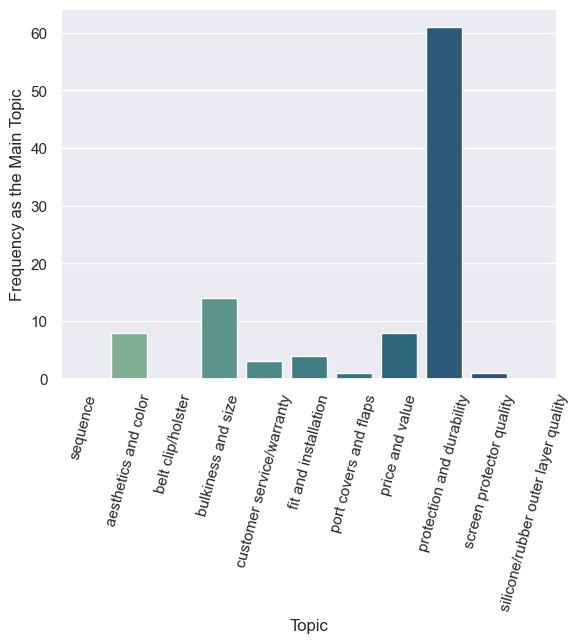

In [13]:
# Produce a bar chart to show frequency of each topic as the main topic
sns.set_theme()
bp = sns.barplot(data = freq_df,
            x="main topic",
            y="count",
            palette="crest",
            )
bp.set_xticklabels(labels = freq_df["main topic"],
                   rotation = 75)
bp.set(xlabel="Topic", ylabel="Frequency as the Main Topic")

C:\Users\darth\AppData\Local\Temp\ipykernel_5944\2948153635.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  kde = sns.kdeplot(data=main_topic_scores, palette="crest")


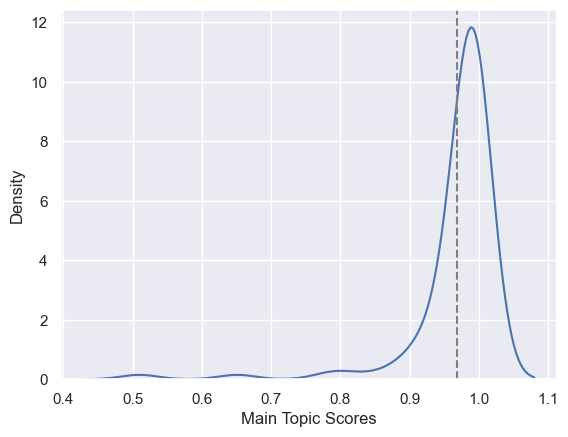

Average main topic score: 0.97


In [14]:
#Create main topic score column
column_indexer = score_table.columns.get_indexer(score_table["main topic"])
column_indexer
main_topic_scores = score_table.values[np.arange(len(score_table)), column_indexer]
main_topic_scores
kde = sns.kdeplot(data=main_topic_scores, palette="crest")
kde.set(xlabel="Main Topic Scores")
plt.axvline(x=np.mean(main_topic_scores), color='grey', linestyle='--')
plt.show()
print(f"Average main topic score: {round(np.mean(main_topic_scores), ndigits=2)}")

We see that aesthetics and weight are not chosen as the main aspect once, suggesting these are not good labels and we should change them. The average score for a main topic is 0.98, suggesting the zero-shot classifier is confident in its predictions. Now it's time to start implementing some sentiment analysis.

In [15]:
import torch
print(torch.__version__)

2.8.0+cpu


In [16]:
review_list = score_table["sequence"].tolist()
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")
sentiment = sentiment_analysis(review_list)


Device set to use cpu


In [17]:
sentiment_df = pd.DataFrame(sentiment).rename(columns={"label":"aspect sentiment", "score":"sentiment score"})
score_table = score_table.reset_index().join(sentiment_df)

In [18]:
score_table.loc[score_table["aspect sentiment"] == "NEGATIVE"]

index                                           sequence  \
8       8  Flap at top left ripped.  Unsightly.  Have own...   
21     21  I bought a couple of these for my wife and dau...   
34     34  I love the protection for my new Apple 4s but ...   
37     37  I purchased this otterbox case because of all ...   
38     38  I purchased this same case in black 2 years ag...   
41     41  I would not recommend this product, it is bulk...   
44     44  It almost feels wrong to put this bulky, clunk...   
51     51  My daughter had this on her new phone and afte...   
63     63  So disappointed with Otterbox these days. Poor...   
70     70  This case does not hold up. It has torn, broke...   
99     99  you know what. It has three layers, and for wh...   

    aesthetics and color  belt clip/holster  bulkiness and size  \
8               0.291161           0.034706            0.420280   
21              0.084092           0.000648            0.986415   
34              0.010782           0.018072            0.998423   
37              0.174544           0.014364            0.844666   
38              0.195938           0.170606            0.505056   
41              0.704781           0.008606            0.993877   
44              0.088752           0.209590            0.990859   
51              0.118301           0.000894            0.071563   
63              0.031937           0.043162            0.996142   
70              0.039326           0.000662            0.219771   
99              0.026040           0.035655            0.613417   

    customer service/warranty  fit and installation  port covers and flaps  \
8                    0.083596              0.296902               0.763236   
21                   0.079806              0.676729               0.018930   
34                   0.173929              0.780298               0.240072   
37                   0.281304              0.855290               0.171568   
38                   0.939978              0.622190               0.298508   
41                   0.305360              0.439492               0.971151   
44                   0.161403              0.807745               0.491346   
51                   0.667732              0.189758               0.349443   
63                   0.369310              0.634279               0.237722   
70                   0.207155              0.317068               0.511160   
99                   0.121462              0.551101               0.783183   

    price and value  protection and durability  screen protector quality  \
8          0.887292                   0.043559                  0.005804   
21         0.475233                   0.976771                  0.149022   
34         0.847327                   0.970224                  0.840434   
37         0.605414                   0.514128                  0.339603   
38         0.717968                   0.646749                  0.109664   
41         0.795568                   0.993999                  0.075716   
44         0.556140                   0.964656                  0.506000   
51         0.407330                   0.807455                  0.543456   
63         0.958302                   0.142927                  0.004178   
70         0.788551                   0.946169                  0.054995   
99         0.366806                   0.753612                  0.283876   

    silicone/rubber outer layer quality                 main topic  \
8                              0.079680            price and value   
21                             0.069320         bulkiness and size   
34                             0.491156         bulkiness and size   
37                             0.000630       fit and installation   
38                             0.085222  customer service/warranty   
41                             0.653021  protection and durability   
44                             0.365658         bulkiness and size   
51                  

So far I can only attribute one aspect to each review, I want to break the sentences down to be able to have more than one aspect for a single review.

In [19]:
from nltk.tokenize import PunktTokenizer

def tokenise_sentences(text):
    if pd.isnull(text):
        return None
    return PunktTokenizer().tokenize(text.strip())

tokenised_reviews = df_filtered_reviews.apply(tokenise_sentences)
tokenised_reviews = tokenised_reviews.explode()
new_review_list = tokenised_reviews.tolist()

In [ ]:
new_score_table = pipe(new_review_list,
    candidate_labels=aspects,
    multi_label=True
)

In [ ]:
new_score_table = pd.DataFrame(new_score_table)
new_score_table = new_score_table.explode(["labels","scores"])
new_score_table = new_score_table.pivot_table(index="sequence",
                            columns="labels",
                            values="scores",
                            aggfunc="mean")


In [ ]:
for col in new_score_table.columns:
    new_score_table[col] = pd.to_numeric(new_score_table[col], errors="coerce")
new_score_table["main topic"] = new_score_table.idxmax(axis=1, numeric_only=True)

In [ ]:
new_score_table = new_score_table.reset_index()

In [ ]:
topics_df=pd.DataFrame(new_score_table.columns.drop("main topic"))
topics_df.rename(columns={"labels" : "main topic"}, inplace=True)
freq_df = pd.DataFrame(new_score_table["main topic"].value_counts()).reset_index()
freq_df = topics_df.merge(freq_df, on="main topic", how="left")
freq_df["count"] = freq_df["count"].fillna(0).astype(int)

C:\Users\darth\AppData\Local\Temp\ipykernel_9988\4109146960.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.barplot(data = freq_df,
C:\Users\darth\AppData\Local\Temp\ipykernel_9988\4109146960.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bp.set_xticklabels(labels = freq_df["main topic"],


[Text(0.5, 0, 'Topic'), Text(0, 0.5, 'Frequency as the Main Topic')]

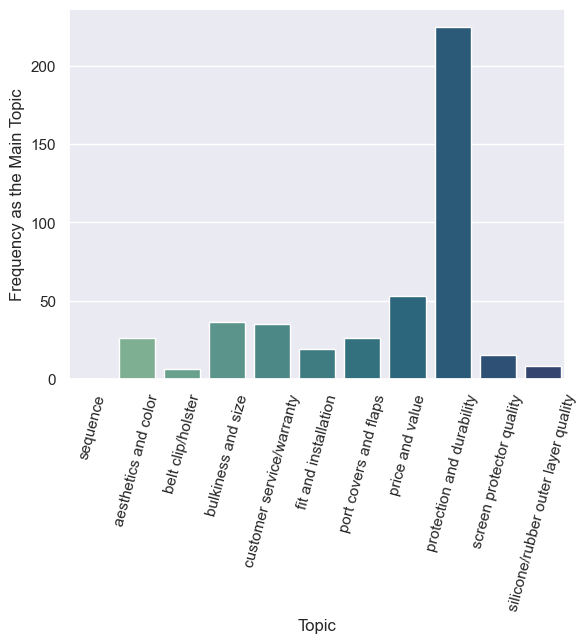

In [ ]:
# Produce a bar chart to show frequency of each topic as the main topic
sns.set_theme()
bp = sns.barplot(data = freq_df,
            x="main topic",
            y="count",
            palette="crest",
            )
bp.set_xticklabels(labels = freq_df["main topic"],
                   rotation = 75)
bp.set(xlabel="Topic", ylabel="Frequency as the Main Topic")

C:\Users\darth\AppData\Local\Temp\ipykernel_9988\934831899.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  kde = sns.kdeplot(data=main_topic_scores, palette="crest")


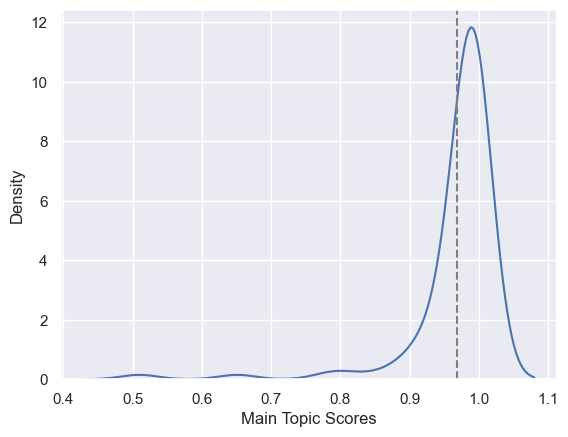

Average main topic score: 0.969


In [ ]:
#Create main topic score column
column_indexer = score_table.columns.get_indexer(score_table["main topic"])
column_indexer
main_topic_scores = score_table.values[np.arange(len(score_table)), column_indexer]
main_topic_scores
kde = sns.kdeplot(data=main_topic_scores, palette="crest")
kde.set(xlabel="Main Topic Scores")
plt.axvline(x=np.mean(main_topic_scores), color='grey', linestyle='--')
plt.show()
print(f"Average main topic score: {round(np.mean(main_topic_scores), ndigits=3)}")

Now weight and aesthetics have some picks as the main topic, this new analysis has caught some opinions that were originally overlooked.

In [ ]:
new_review_list = new_score_table["sequence"].tolist()
new_sentiment = sentiment_analysis(new_review_list)

In [ ]:
sentiment_df = pd.DataFrame(new_sentiment).rename(columns={"label":"aspect sentiment", "score":"sentiment score"})
new_score_table = new_score_table.reset_index().join(sentiment_df)

In [ ]:
new_score_table["sentiment score"] = np.where(new_score_table["aspect sentiment"] == "NEGATIVE", new_score_table["sentiment score"] * -1, new_score_table["sentiment score"])

In [ ]:
new_score_table

index                                           sequence  \
0        0                                                  !   
1        1                                             !!!!!!   
2        2  ***UPDATE- I just filed a claim with Otterbox,...   
3        3          2) The screen protector is crystal clear.   
4        4  3) Survivor covers all ports for moisture/dust...   
..     ...                                                ...   
444    444  this is a great case, fits the phone nicely, a...   
445    445  very good protection but is quite bulky  recom...   
446    446                           when they're not in use.   
447    447  you can literally through your phone against t...   
448    448                                     you know what.   

     aesthetics and color  belt clip/holster  bulkiness and size  \
0                0.394684           0.472292            0.102605   
1                0.244778           0.333618            0.070423   
2                0.174290           0.047125            0.213395   
3                0.297159           0.000879            0.000655   
4                0.010194           0.314862            0.068450   
..                    ...                ...                 ...   
444              0.431794           0.000108            0.111558   
445              0.001265           0.125437            0.993139   
446              0.169542           0.436081            0.243726   
447              0.039624           0.000741            0.169273   
448              0.620030           0.592072            0.179025   

     customer service/warranty  fit and installation  port covers and flaps  \
0                     0.456836              0.264269               0.483011   
1                     0.315333              0.044951               0.455831   
2                     0.981131              0.692404               0.166500   
3                     0.512596              0.394014               0.010042   
4                     0.086313              0.221830               0.887873   
..                         ...                   ...                    ...   
444                   0.295627              0.980605               0.120344   
445                   0.073826              0.375213               0.386663   
446                   0.150343              0.026528               0.628974   
447                   0.129311              0.045132               0.051468   
448                   0.698733              0.431750               0.416993   

     price and value  protection and durability  screen protector quality  \
0           0.339721                   0.421478                  0.336467   
1           0.259933                   0.187965                  0.143608   
2           0.670657                   0.755519                  0.344131   
3           0.110992                   0.954041                  0.989799   
4           0.147579                   0.961625                  0.839592   
..               ...                        ...                       ...   
444         0.968641                   0.999078                  0.937753   
445         0.332983                   0.976382                  0.772195   
446         0.278946                   0.470627                  0.335716   
447         0.078512                   0.666841                  0.341384   
448         0.582895                   0.596681                  0.468167   

     silicone/rubber outer layer quality                 main topic  \
0                               0.433406      port covers and flaps   
1                               0.369354      port covers and flaps   
2                               0.315014  customer service/warranty   
3                               0.225774   screen protector quality   
4                               0.325460  protection and durability   
..                                   ...                        ...   
444                             0.51

In [ ]:
aspect_summary = new_score_table.drop(columns=["index", "sequence"])
aspect_summary = aspect_summary.groupby("main topic").agg(
    aspect_count = ("main topic", "size"),
    positive_count=("aspect sentiment", lambda x: (x == "POSITIVE").sum()),
    negative_count=("aspect sentiment", lambda x: (x == "NEGATIVE").sum()),
    average_sentiment_score=("sentiment score", "mean")
).reset_index()

In [ ]:
aspect_summary.rename(columns={"main topic":"aspect"}, inplace=True)

In [ ]:
aspect_summary.sort_values(by='average_sentiment_score', ascending=False, inplace=True)
aspect_summary

aspect  aspect_count  positive_count  \
0                 aesthetics and color            26              24   
7            protection and durability           225             177   
3            customer service/warranty            35              24   
4                 fit and installation            19              13   
8             screen protector quality            15              10   
6                      price and value            53              27   
1                    belt clip/holster             6               3   
2                   bulkiness and size            36              14   
5                port covers and flaps            26               7   
9  silicone/rubber outer layer quality             8               2   

   negative_count  average_sentiment_score  
0               2                 0.843025  
7              48                 0.573655  
3              11                 0.370884  
4               6                 0.367401  
8               5                 0.332915  
6              26                 0.017264  
1               3                -0.000264  
2              22                -0.221155  
5              19                -0.461955  
9               6                -0.499831

Great, this table is what I was after! You can see this product is celebrated for its quality and fit, but is criticised for its weight, bulkiness and price. I want to turn this into a set of graphics to inform the user.

C:\Users\darth\AppData\Local\Temp\ipykernel_9988\2056975474.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="average_sentiment_score", y="aspect", data=aspect_summary, palette=colour_list)


(-1.0, 1.0)

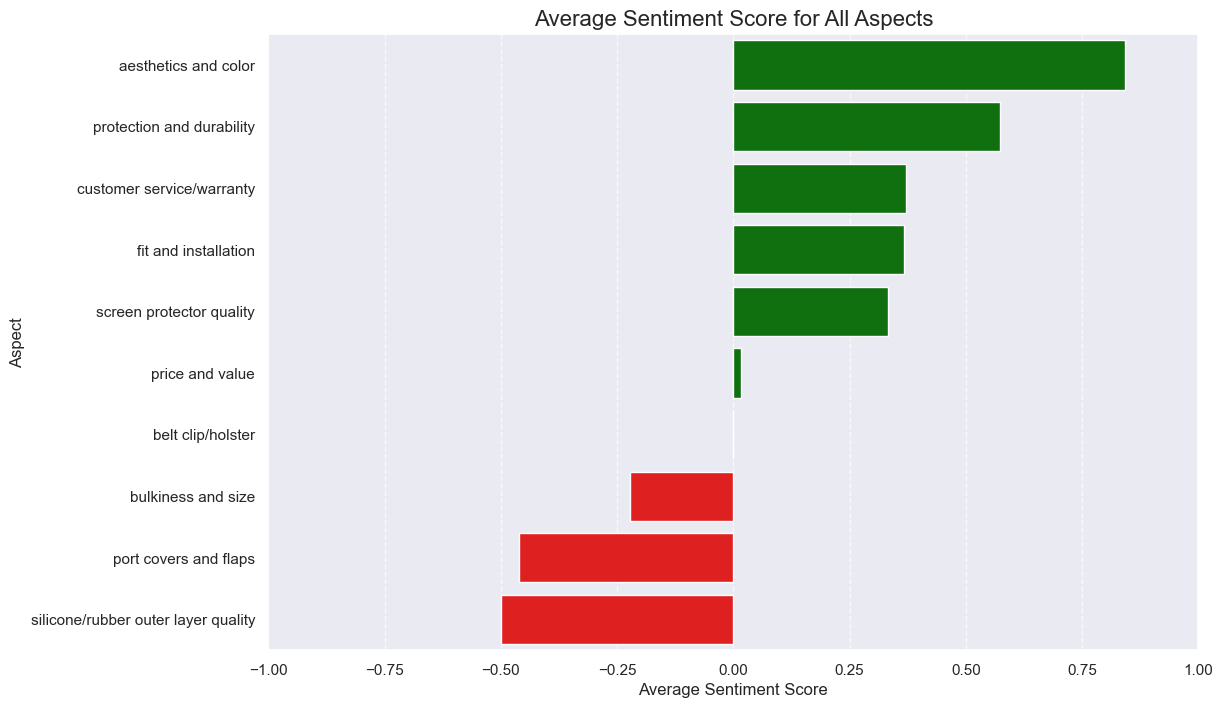

In [ ]:
colour_list = []
for i in aspect_summary["average_sentiment_score"]:
    if i >= 0:
        colour_list.append("green")
    else:
        colour_list.append("red")

plt.figure(figsize=(12, 8))
sns.barplot(x="average_sentiment_score", y="aspect", data=aspect_summary, palette=colour_list)
plt.title("Average Sentiment Score for All Aspects", fontsize=16)
plt.xlabel("Average Sentiment Score")
plt.ylabel("Aspect")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.xlim(-1, 1)